In [8]:
import os
import urllib
from collections import Counter
from zipfile import ZipFile
import pandas as pd
import glob
from multiprocessing import Pool
pd.set_option('display.max_colwidth', -1)    

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from src import util
from src.data.gdelt_event_2 import mentions
from multiprocessing.dummy import Pool as DummyPool


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Format is YYYMMDDHHmmSS

YEAR = "2018"
MONTH = "07"
# There are also some other files for each timeframe which we won't use for now.
# The others are .gkg.csv.zip and .mentions.CSV.zip
FILEENDING = ".export.CSV.zip" # There are also some other files for each timeframe which we won't use for now.
with open(os.environ["DATA_PATH"] + "/external/masterfilelist.txt") as f:
    def task(url):
        file_name = url.split("/")[-1]
        file_path = os.environ["DATA_PATH"] + "/external/GDELT/" + file_name
        if os.path.isfile(file_path):
            return "Already exists"# If it already exists, we don't need to download again
        try:
            urllib.request.urlretrieve (url, file_path)
            return "Success"
        except Exception as e:
            return str(e)
    
    urls = list()
    malformed_lines = 0
    for line in f:
        try:
            url = line.rstrip("\n").split(" ")[2]
            file_name = url.split("/")[-1]
            if file_name.startswith(YEAR+MONTH) and file_name.endswith(FILEENDING):
                urls.append(url)
        except Exception as e:
            malformed_lines+=1
            pass
            #print(line) # Why are some lines just "http://data.gdeltproject.org/gdeltv2/"?!
    
    print("%d malformed lines, %d urls scheduled for download" % (malformed_lines, len(urls)))
    
    pool = DummyPool(16) # using dummypool here because for whatever reason the other one doesn't get proper bandwidth
    results = list()
    for result in pool.imap(task, urls):
        results.append(result)
        if len(results) % 500 == 0:
            print(len(results))
    pool.close()
    pool.join()
    
Counter(results)

49 malformed lines, 2913 urls scheduled for download
500
1000
1500
2000
2500


Counter({'Already exists': 2913})

In [3]:
# Check Download for completeness
missing = 0
for day in range(1, 31):
    for hour in range(0,23):
        for quarter in range(0,3):
            if not os.path.isfile(util.get_GDELT_file_path(2018,7,day,hour,quarter)):
                #print("File %s is missing" % file_name)
                missing += 1

# Some files are missing for some reason
print("%d of %d files missing." % (missing, 31*24*4))

43 of 2976 files missing.


In [16]:
with open(os.environ["DATA_PATH"] + "/external/masterfilelist.txt") as f:
    for line in f:
        try:
            url = line.rstrip("\n").split(" ")[2]
            file_name = url.split("/")[-1]
            if file_name.startswith("2018070118"):
                print(url)
        except:
            pass

http://data.gdeltproject.org/gdeltv2/20180701180000.export.CSV.zip
http://data.gdeltproject.org/gdeltv2/20180701180000.mentions.CSV.zip
http://data.gdeltproject.org/gdeltv2/20180701180000.gkg.csv.zip
http://data.gdeltproject.org/gdeltv2/20180701183000.export.CSV.zip
http://data.gdeltproject.org/gdeltv2/20180701183000.mentions.CSV.zip
http://data.gdeltproject.org/gdeltv2/20180701183000.gkg.csv.zip
http://data.gdeltproject.org/gdeltv2/20180701184500.export.CSV.zip
http://data.gdeltproject.org/gdeltv2/20180701184500.mentions.CSV.zip
http://data.gdeltproject.org/gdeltv2/20180701184500.gkg.csv.zip


In [14]:
# THE DOCS ARE MISSING "Actor1Geo_ADM1Code", "Actor2Geo_ADM2Code",  "ActionGeo_ADM2Code"
df = pd.read_csv(util.get_GDELT_file_path(), compression='zip', delimiter="\t", names=util.GDELT_HEADER)
#df.drop_duplicates("SOURCEURL")["SOURCEURL"].head(50)
df.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,769161300,20170703,201707,2017,2017.5014,NaN,NaN,NaN,NaN,NaN,...,4,"Budapest, Budapest, Hungary",HU,HU05,17514,47.5000,19.083300,-850553,20180703150000,http://hungarianfreepress.com/2018/07/03/wave-of-hungarians-deported-from-the-us/
1,769161301,20170703,201707,2017,2017.5014,COL,COLOMBIA,COL,NaN,NaN,...,1,Colombia,CO,CO,NaN,4.0000,-72.000000,CO,20180703150000,http://www.cyclist.co.uk/news/4982/team-sky-confirm-riders-to-support-chris-froome-at-tour-de-france
2,769161302,20170703,201707,2017,2017.5014,GOV,PRESIDENT,NaN,NaN,NaN,...,2,"Utah, United States",US,USUT,NaN,40.1135,-111.854000,UT,20180703150000,https://www.sltrib.com/news/politics/2018/07/02/utahns-support-allowing/
3,769161303,20170703,201707,2017,2017.5014,HTIGOV,HAITI,HTI,NaN,NaN,...,1,Haiti,HA,HA,NaN,19.0000,-72.416667,HA,20180703150000,https://www.sltrib.com/news/politics/2018/07/02/utahns-support-allowing/
4,769161304,20170703,201707,2017,2017.5014,HTIGOV,HAITI,HTI,NaN,NaN,...,2,"Utah, United States",US,USUT,NaN,40.1135,-111.854000,UT,20180703150000,https://www.sltrib.com/news/politics/2018/07/02/utahns-support-allowing/


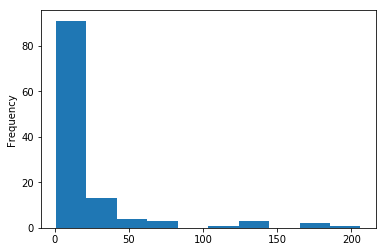

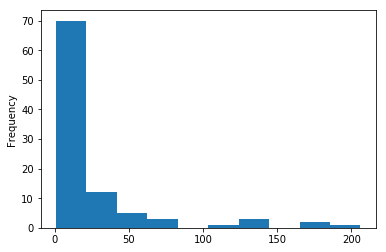

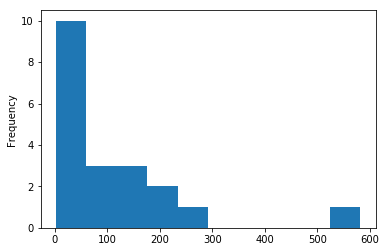

In [73]:
df["EventCode"].value_counts().plot.hist()
plt.show()
df["EventBaseCode"].value_counts().plot.hist()
plt.show()
df["EventRootCode"].value_counts().plot.hist()
plt.show()

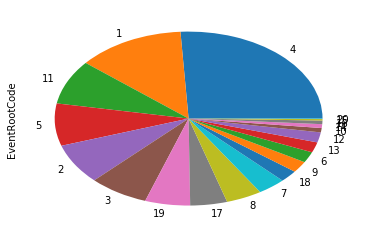

In [78]:
df["EventRootCode"].value_counts().plot.pie()
plt.show()

# Mentions

In [13]:
pd.read_csv(os.environ["DATA_PATH"] + "/external/GDELT/mentions/20180701000000.mentions.csv.zip", compression='zip', header=None, names=["GlobalEventID", "MentionIdentifier", "Confidence"], delimiter="\t", usecols=[0,5,11])

,GlobalEventID,MentionIdentifier,Confidence
0,768548763,http://www.koamtv.com/story/38536522/hundreds-of-syrians-leave-lebanon-for-long-awaited-reunions,20
1,768548764,https://movieweb.com/batman-v-superman-kevin-smith-wanted-christian-bale/,50
2,768548765,https://movieweb.com/batman-v-superman-kevin-smith-wanted-christian-bale/,50
3,669533318,https://www.ballymoneytimes.co.uk/news/ballymoney-will-never-be-the-same-again-s-alex-blair-1-7191817,60
4,768548766,https://www.thetimes.co.uk/edition/business/inga-beales-unfinished-business-after-leaving-lloyds-of-london-xngx96hp5,30
5,768548767,https://www.thetimes.co.uk/edition/news/come-clean-on-extra-pay-mps-told-ljncjtd0p,20
6,768548768,https://www.thetimes.co.uk/edition/news/come-clean-on-extra-pay-mps-told-ljncjtd0p,80
7,768548769,http://the-japan-news.com/news/article/0004551307,100
8,768548770,http://www.carmitimes.com/zz/news/20180630/trump-claims-saudi-arabia-will-boost-oil-production,80
9,768548770,http://www.sentinel-standard.com/zz/news/20180630/trump-claims-saudi-arabia-will-boost-oil-production,80


17519003
